In [ ]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image

from socket import timeout

from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -q "/content/drive/My Drive/internship_data.zip"

In [ ]:
female_folder = 'internship_data/female'
male_folder = 'internship_data/male'
print('Number of female pics: %i'%(len(os.listdir(female_folder))))
print('Number of male pics: %i'%(len(os.listdir(male_folder))))

Number of female pics: 50002
Number of male pics: 50002


In [ ]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0")

In [ ]:
male_pictures = [name for name in os.listdir(male_folder) if '.jpg' in name]
female_pictures = [name for name in os.listdir(female_folder) if '.jpg' in name]

In [ ]:
number_of_intersects = len(np.intersect1d(male_pictures, female_pictures))
print('There is %i intersects in names of female and male pics' %(number_of_intersects))

There is 0 intersects in names of female and male pics


In [ ]:
class MaleFemaleDataset(Dataset):
    """Датасет для PyTorch"""
    def __init__(self, folder, male_pics, female_pics, transform=None):
        self.transform = transform
        self.folder = folder
        self.male_pics = male_pics
        self.female_pics = female_pics
        self.all_pics = male_pics + female_pics

    def __len__(self):
        return len(self.all_pics)

    def __getitem__(self, index):
        img_id = self.all_pics[index]
        if img_id in self.male_pics:
            y = 1
            img_path = os.path.join(self.folder, 'male', img_id)
        elif img_id in self.female_pics:
            y = 0
            img_path = os.path.join(self.folder, 'female', img_id)

        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        return img, y, img_id


def visualise_samples(dataset, indices, title=None, count=10):
    """Функция для визуализации случайных count картинок из датасета."""
    plt.figure(figsize=(count*3, 3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))
    for i, index in enumerate(display_indices):
        x, y, _ = dataset[index]
        plt.subplot(1, count, i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')

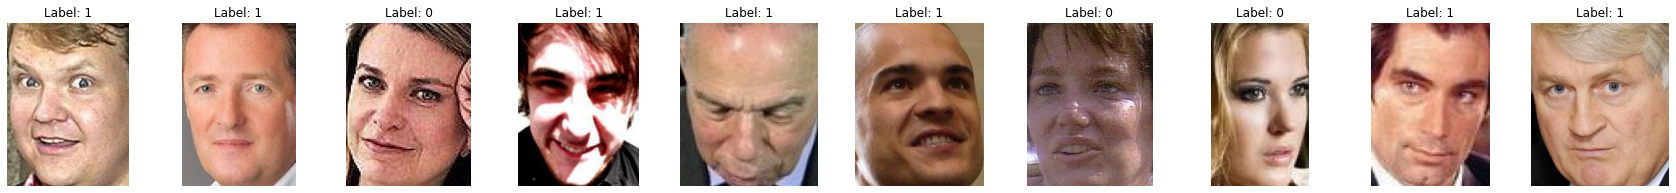

In [ ]:
#загрузка данных для визуализации
orig_dataset = MaleFemaleDataset('/content/internship_data', male_pictures, female_pictures)
indices = np.random.choice(np.arange(len(orig_dataset)), 10, replace=False)

visualise_samples(orig_dataset, indices)

1 - male, 0 - female

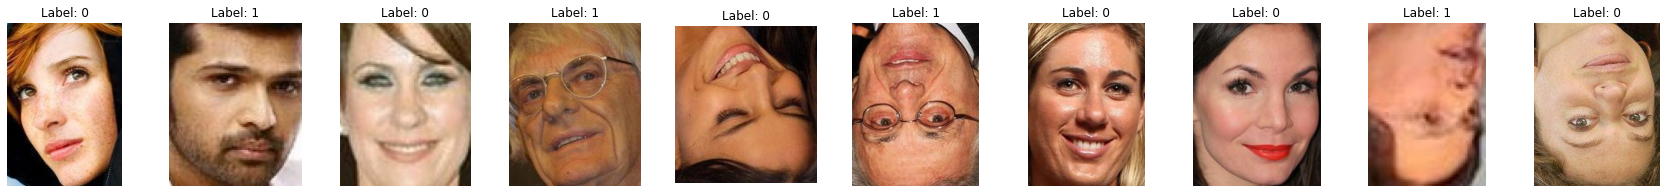

In [ ]:
#убеждаемся, что transform работает
dataset = MaleFemaleDataset('/content/internship_data', male_pictures, female_pictures, transform=transforms.RandomVerticalFlip(0.5))
indices = np.random.choice(np.arange(len(dataset)), 10, replace=False)
visualise_samples(dataset, indices)

In [ ]:
#загрузка данных с аугментациями (2000 мужских фото и 2000 женских)
train_dataset = MaleFemaleDataset('/content/internship_data', male_pictures[:2000], female_pictures[:2000], 
                                  transform=transforms.Compose([
                                            transforms.Resize((112, 112)),
                                            transforms.RandomGrayscale(p=0.1),
                                            transforms.RandomRotation(10),
                                            transforms.ColorJitter(hue=.1, saturation=.1),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                  std=[0.229, 0.224, 0.225])                         
                       ]))

In [ ]:
#создание лоадеров
batch_size = 64

data_size = len(train_dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)

In [ ]:
#описываем необходимые функции
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, step_size, gamma):
    """Функция для тренировки модели"""
    loss_history = []
    train_history = []
    val_history = []
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        scheduler.step()
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Считает accuracy модели по лоадеру
    """
    model.eval()
    correct_samples, total_samples = 0, 0
    for i_step, (x, y,_) in enumerate(loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device) 

            prediction = model(x_gpu)    

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
    
    return float(correct_samples) / total_samples

In [ ]:
#пробую pretrained resnet50 на данных с аугментациями
import torch.nn as nn
import torch.optim as optim

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.005, weight_decay=1e-5)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5, 1, 0.9)

Average loss: 0.534073, Train accuracy: 0.767188, Val accuracy: 0.836250
Average loss: 0.335882, Train accuracy: 0.856875, Val accuracy: 0.772500
Average loss: 0.346687, Train accuracy: 0.851562, Val accuracy: 0.836250
Average loss: 0.323481, Train accuracy: 0.865938, Val accuracy: 0.857500
Average loss: 0.286060, Train accuracy: 0.875938, Val accuracy: 0.850000


In [ ]:
#перебор параметров (learning rate, regularization)
from collections import namedtuple

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])
 
learning_rates = [1e-3, 3e-3, 5e-3]
anneal_coeff = 0.2
anneal_epochs = [5]
reg = [1e-5, 1e-6]
gs = 0.2

batch_size = 64
epoch_num = 15

run_record = {} 
 
for lr in learning_rates:
    for lam in reg:
        for n in anneal_epochs:
            print(f'step size = {n} learning rate lr = {lr}, regularization lam = {lam}')
            model = models.resnet50(pretrained=True)
            for param in model.parameters():
                param.requires_grad = False

            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, 2)

            model = model.to(device)

            loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
            optimizer = optim.Adam(model.fc.parameters(), lr=lr, weight_decay=lam)
            loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, epoch_num, anneal_coeff, anneal_epochs[0])
            run_record[Hyperparams(lr, n, lam)] = RunResult('com', train_history, val_history, val_history[-1])

step size = 5 learning rate lr = 0.001, regularization lam = 1e-05
Average loss: 0.492403, Train accuracy: 0.767500, Val accuracy: 0.833750
Average loss: 0.350062, Train accuracy: 0.851562, Val accuracy: 0.863750
Average loss: 0.313890, Train accuracy: 0.865938, Val accuracy: 0.856250
Average loss: 0.308440, Train accuracy: 0.865625, Val accuracy: 0.855000
Average loss: 0.291909, Train accuracy: 0.876563, Val accuracy: 0.872500
Average loss: 0.299739, Train accuracy: 0.867500, Val accuracy: 0.836250
Average loss: 0.294433, Train accuracy: 0.868437, Val accuracy: 0.862500
Average loss: 0.277172, Train accuracy: 0.885000, Val accuracy: 0.863750
Average loss: 0.288962, Train accuracy: 0.877500, Val accuracy: 0.861250
Average loss: 0.280957, Train accuracy: 0.877188, Val accuracy: 0.866250
Average loss: 0.262150, Train accuracy: 0.893125, Val accuracy: 0.861250
Average loss: 0.252836, Train accuracy: 0.898750, Val accuracy: 0.866250
Average loss: 0.265655, Train accuracy: 0.887813, Val acc

In [ ]:
run_record
#оптимальные параметры (learning_rate=0.005, anneal_epochs=5, reg=1e-06)

{Hyperparams(learning_rate=0.001, anneal_epochs=5, reg=1e-06): RunResult(model='com', train_history=[0.784375, 0.863125, 0.864375, 0.8753125, 0.878125, 0.8596875, 0.87375, 0.8778125, 0.8828125, 0.875625, 0.884375, 0.895625, 0.890625, 0.8921875, 0.89375], val_history=[0.8425, 0.86125, 0.86375, 0.855, 0.85, 0.8475, 0.86625, 0.85125, 0.85, 0.86625, 0.86875, 0.86, 0.86, 0.87125, 0.865], final_val_accuracy=0.865),
 Hyperparams(learning_rate=0.001, anneal_epochs=5, reg=1e-05): RunResult(model='com', train_history=[0.7675, 0.8515625, 0.8659375, 0.865625, 0.8765625, 0.8675, 0.8684375, 0.885, 0.8775, 0.8771875, 0.893125, 0.89875, 0.8878125, 0.8965625, 0.894375], val_history=[0.83375, 0.86375, 0.85625, 0.855, 0.8725, 0.83625, 0.8625, 0.86375, 0.86125, 0.86625, 0.86125, 0.86625, 0.8675, 0.86375, 0.85375], final_val_accuracy=0.85375),
 Hyperparams(learning_rate=0.003, anneal_epochs=5, reg=1e-06): RunResult(model='com', train_history=[0.78875, 0.860625, 0.85875, 0.859375, 0.87625, 0.8825, 0.8809375

In [ ]:
# Пробую pretrained densenet201
import torch.nn as nn
import torch.optim as optim

model = models.densenet201(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Linear(1920, 2)

model = model.to(device)
model.type(torch.cuda.FloatTensor)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.005, weight_decay=1e-5)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 15, 5, 0.2)

Average loss: 0.454323, Train accuracy: 0.798438, Val accuracy: 0.846250
Average loss: 0.277909, Train accuracy: 0.878437, Val accuracy: 0.862500
Average loss: 0.250556, Train accuracy: 0.890000, Val accuracy: 0.852500
Average loss: 0.311352, Train accuracy: 0.878437, Val accuracy: 0.828750
Average loss: 0.273309, Train accuracy: 0.889687, Val accuracy: 0.860000
Average loss: 0.191500, Train accuracy: 0.925937, Val accuracy: 0.856250
Average loss: 0.196098, Train accuracy: 0.927188, Val accuracy: 0.862500
Average loss: 0.175215, Train accuracy: 0.927188, Val accuracy: 0.862500
Average loss: 0.180270, Train accuracy: 0.929375, Val accuracy: 0.860000
Average loss: 0.166414, Train accuracy: 0.934063, Val accuracy: 0.865000
Average loss: 0.174362, Train accuracy: 0.932813, Val accuracy: 0.862500
Average loss: 0.169337, Train accuracy: 0.926875, Val accuracy: 0.853750
Average loss: 0.171121, Train accuracy: 0.930625, Val accuracy: 0.863750
Average loss: 0.165036, Train accuracy: 0.932813, V

All Data

In [ ]:
# Загружаю все данные с аугментациями
train_dataset = MaleFemaleDataset('/content/internship_data', male_pictures, female_pictures, 
                                  transform=transforms.Compose([
                                            transforms.Resize((112, 112)),
                                            transforms.RandomGrayscale(p=0.1),
                                            transforms.RandomRotation(10),
                                            transforms.ColorJitter(hue=.1, saturation=.1),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                  std=[0.229, 0.224, 0.225])                         
                       ]))

batch_size = 128

data_size = len(train_dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)

In [ ]:
# Пытаюсь вновь тренировать реснет50 на всех данных с аугментациями
import torch.nn as nn
import torch.optim as optim

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=1e-5)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 10, 1, 0.9)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Average loss: 0.365765, Train accuracy: 0.834879, Val accuracy: 0.850650
Average loss: 0.327436, Train accuracy: 0.858979, Val accuracy: 0.858350
Average loss: 0.317602, Train accuracy: 0.862216, Val accuracy: 0.844000
Average loss: 0.308149, Train accuracy: 0.867928, Val accuracy: 0.873150
Average loss: 0.302184, Train accuracy: 0.871441, Val accuracy: 0.860300
Average loss: 0.299467, Train accuracy: 0.872528, Val accuracy: 0.868200
Average loss: 0.297157, Train accuracy: 0.873253, Val accuracy: 0.833200
Average loss: 0.294966, Train accuracy: 0.874041, Val accuracy: 0.875850
Average loss: 0.292533, Train accuracy: 0.875753, Val accuracy: 0.875750
Average loss: 0.291707, Train accuracy: 0.876166, Val accuracy: 0.871700


In [ ]:
torch.save(model, '/content/drive/My Drive/model')

In [ ]:
# тренировка densenet201 на всех данных с аугментациями
import torch.nn as nn
import torch.optim as optim

dense_model = models.densenet201(pretrained=True)
for param in dense_model.parameters():
    param.requires_grad = False

dense_model.classifier = nn.Linear(1920, 2)

dense_model = dense_model.to(device)
dense_model.type(torch.cuda.FloatTensor)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(dense_model.classifier.parameters(), lr=0.001, weight_decay=1e-5)
loss_history, train_history, val_history = train_model(dense_model, train_loader, val_loader, loss, optimizer, 10, 5, 0.2)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth



Average loss: 0.353654, Train accuracy: 0.844466, Val accuracy: 0.861450
Average loss: 0.320250, Train accuracy: 0.862841, Val accuracy: 0.861500
Average loss: 0.317116, Train accuracy: 0.864441, Val accuracy: 0.842100
Average loss: 0.322628, Train accuracy: 0.862528, Val accuracy: 0.859000
Average loss: 0.314799, Train accuracy: 0.865716, Val accuracy: 0.860550
Average loss: 0.304236, Train accuracy: 0.870353, Val accuracy: 0.868000
Average loss: 0.298872, Train accuracy: 0.873128, Val accuracy: 0.864650
Average loss: 0.300994, Train accuracy: 0.872741, Val accuracy: 0.869900
Average loss: 0.301100, Train accuracy: 0.872353, Val accuracy: 0.867000
Average loss: 0.299607, Train accuracy: 0.872216, Val accuracy: 0.871600


In [ ]:
#загружаю все данные без аугментаций
train_dataset = MaleFemaleDataset('/content/internship_data', male_pictures, female_pictures, 
                                  transform=transforms.Compose([
                                            transforms.Resize((112, 112)),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                  std=[0.229, 0.224, 0.225])                         
                       ]))

batch_size = 128

data_size = len(train_dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=1e-5)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 10, 1, 0.9)

Average loss: 0.304504, Train accuracy: 0.868791, Val accuracy: 0.875550
Average loss: 0.267635, Train accuracy: 0.888240, Val accuracy: 0.850150
Average loss: 0.259956, Train accuracy: 0.892390, Val accuracy: 0.858900
Average loss: 0.249702, Train accuracy: 0.897190, Val accuracy: 0.897150
Average loss: 0.247197, Train accuracy: 0.896640, Val accuracy: 0.871400
Average loss: 0.240034, Train accuracy: 0.899828, Val accuracy: 0.894400
Average loss: 0.232652, Train accuracy: 0.902665, Val accuracy: 0.899750
Average loss: 0.232394, Train accuracy: 0.904040, Val accuracy: 0.902300
Average loss: 0.232664, Train accuracy: 0.904177, Val accuracy: 0.900500
Average loss: 0.228984, Train accuracy: 0.905715, Val accuracy: 0.900600


In [ ]:
#реснет50 показала 0.9 accuracy, сохраняем
torch.save(model, '/content/drive/My Drive/new_model')

In [ ]:
#пробую гуглнет
model = models.googlenet(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=1e-5)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 10, 1, 0.9)

Average loss: 0.368043, Train accuracy: 0.837329, Val accuracy: 0.862650
Average loss: 0.338995, Train accuracy: 0.851891, Val accuracy: 0.862550
Average loss: 0.336672, Train accuracy: 0.853891, Val accuracy: 0.863800
Average loss: 0.335888, Train accuracy: 0.853891, Val accuracy: 0.867150
Average loss: 0.333642, Train accuracy: 0.854991, Val accuracy: 0.859700
Average loss: 0.332459, Train accuracy: 0.856541, Val accuracy: 0.865300
Average loss: 0.334729, Train accuracy: 0.854166, Val accuracy: 0.865100
Average loss: 0.333788, Train accuracy: 0.855891, Val accuracy: 0.867200
Average loss: 0.331606, Train accuracy: 0.856041, Val accuracy: 0.864500
Average loss: 0.332942, Train accuracy: 0.854966, Val accuracy: 0.867200


In [ ]:
# пробую реснет101
model = models.resnet101(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=1e-5)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 20, 1, 0.99)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth



Average loss: 0.314298, Train accuracy: 0.864528, Val accuracy: 0.867250
Average loss: 0.273779, Train accuracy: 0.884903, Val accuracy: 0.777100
Average loss: 0.265215, Train accuracy: 0.889590, Val accuracy: 0.888450
Average loss: 0.255218, Train accuracy: 0.893578, Val accuracy: 0.862900
Average loss: 0.248746, Train accuracy: 0.895965, Val accuracy: 0.896050
Average loss: 0.245538, Train accuracy: 0.898428, Val accuracy: 0.893000
Average loss: 0.242502, Train accuracy: 0.898640, Val accuracy: 0.893400
Average loss: 0.240674, Train accuracy: 0.899903, Val accuracy: 0.898550
Average loss: 0.231327, Train accuracy: 0.903315, Val accuracy: 0.899150
Average loss: 0.231402, Train accuracy: 0.904390, Val accuracy: 0.871000
Average loss: 0.232660, Train accuracy: 0.903727, Val accuracy: 0.881150
Average loss: 0.230569, Train accuracy: 0.904315, Val accuracy: 0.888750
Average loss: 0.228551, Train accuracy: 0.905315, Val accuracy: 0.873950
Average loss: 0.229547, Train accuracy: 0.905777, 

In [ ]:
#на всякий случай сохраняю
torch.save(model, '/content/drive/My Drive/resnet101_20eps')